# Predicting future actor collaborations using Graph Analytics in Neo4j

## Introduction

* **Objective**: use graph features to predict future collaboration between actors based on previous collaboration.

* 4 models are trained and tested using different set of graph features.

* The last section presents the importance of each of the features used on the prediction performance.

* The graph parameters used are: Common neighbors, preferential attachment, total neighbors, triangles count, clustering coefficient, Louvain coefficient, and partition community detection.

Note: this paper is based on the notebook ‘Analyze netflix data using graphs (neo4j)’ published by [Yann Claudel.](https://www.kaggle.com/code/yclaudel/analyze-netflix-data-using-graphs-neo4j)


Diagram of the nodes and relationships

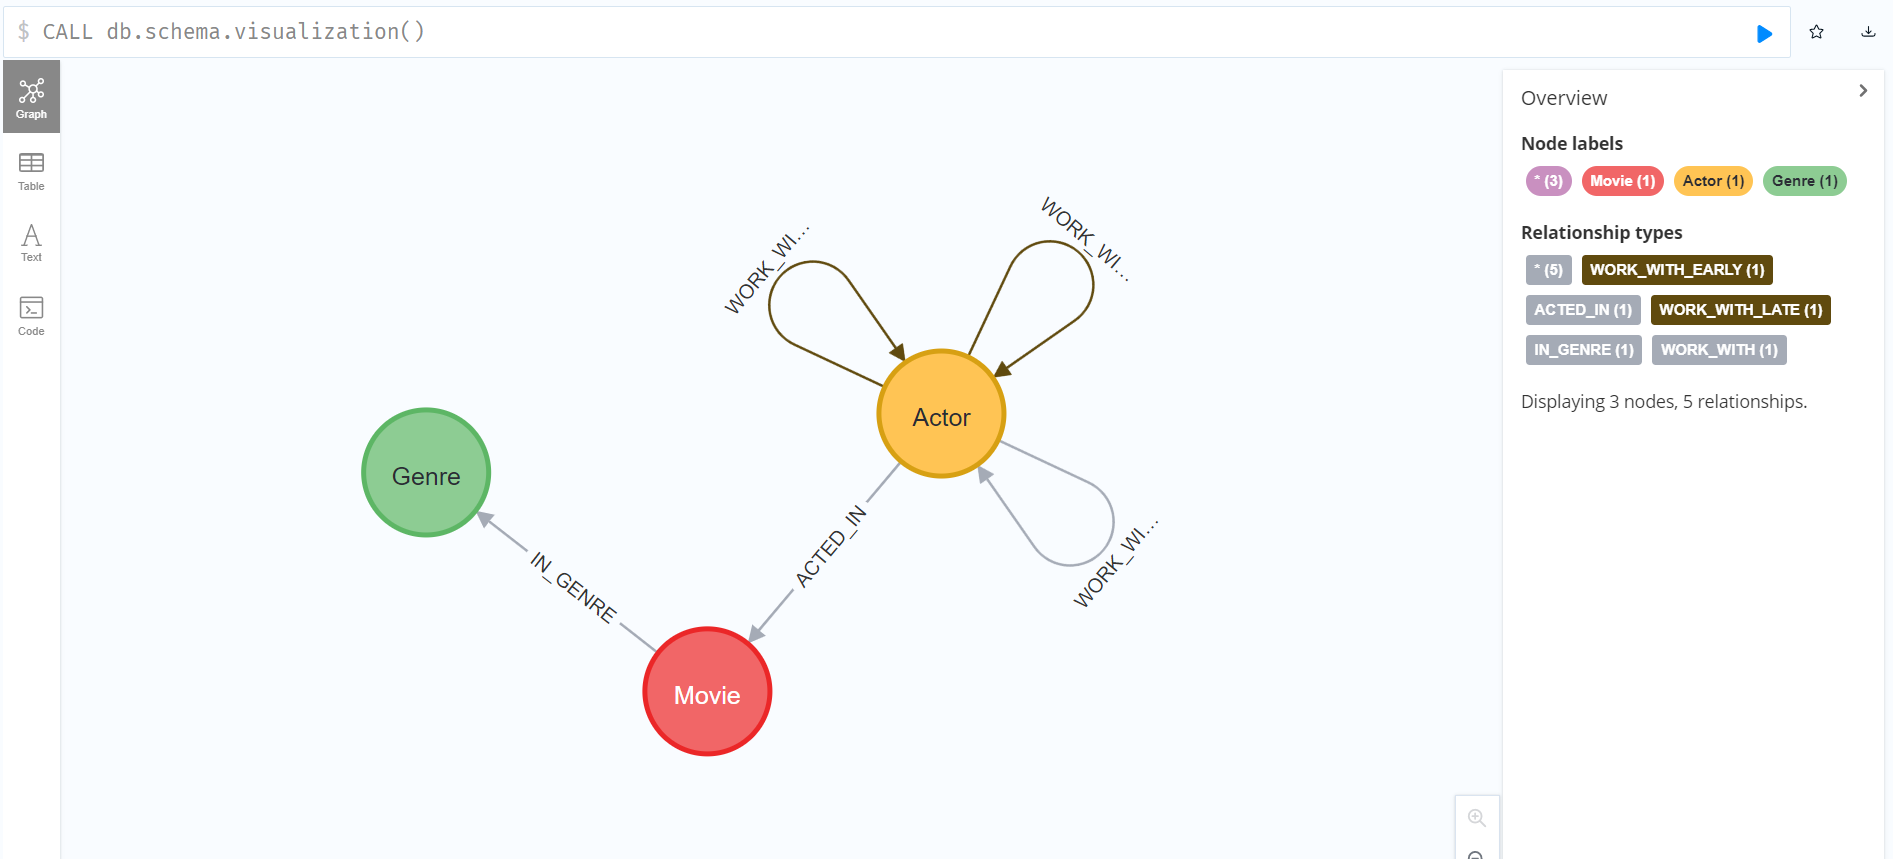

# Neoj4 configuration

To interact with Neo4j, you need a Sandbox Neo4j.
​
For this project, I am using the Neo4j desktop version and running the sandbox in my localhost browser, you can install Neo4j following the instruction in this [link](https://neo4j.com/download/).
​
An online sandbox can be launched for 3 days [here](https://neo4j.com/sandbox/), you just have to sign in.
​
In this notebook, I am connecting with my localhost running Neo4j installed in my desktop.
​
**Steps to connect Neo4j desktop and Jupiter notebook:**
​
* Run the neo4j desktop app
* Create a new project (+new button)
* Within the project, create a new Graph DBMS (+add button)
* Select the 'Local DBMS' option in the menu
* When creating the Graph DBMS, select a password and write it down as you will need it later.
* This notebook is using the 5.3.0 neo4j version **5.3.0**
* Once created, click it to open the option toolbar on the right hand side, select the Plugins option and install APOC and Graph Data Science Library
* Then, click on the three dots next to the open button, and select settings
* Go to the button of the text file and change the memory.heap.max_size by 6G

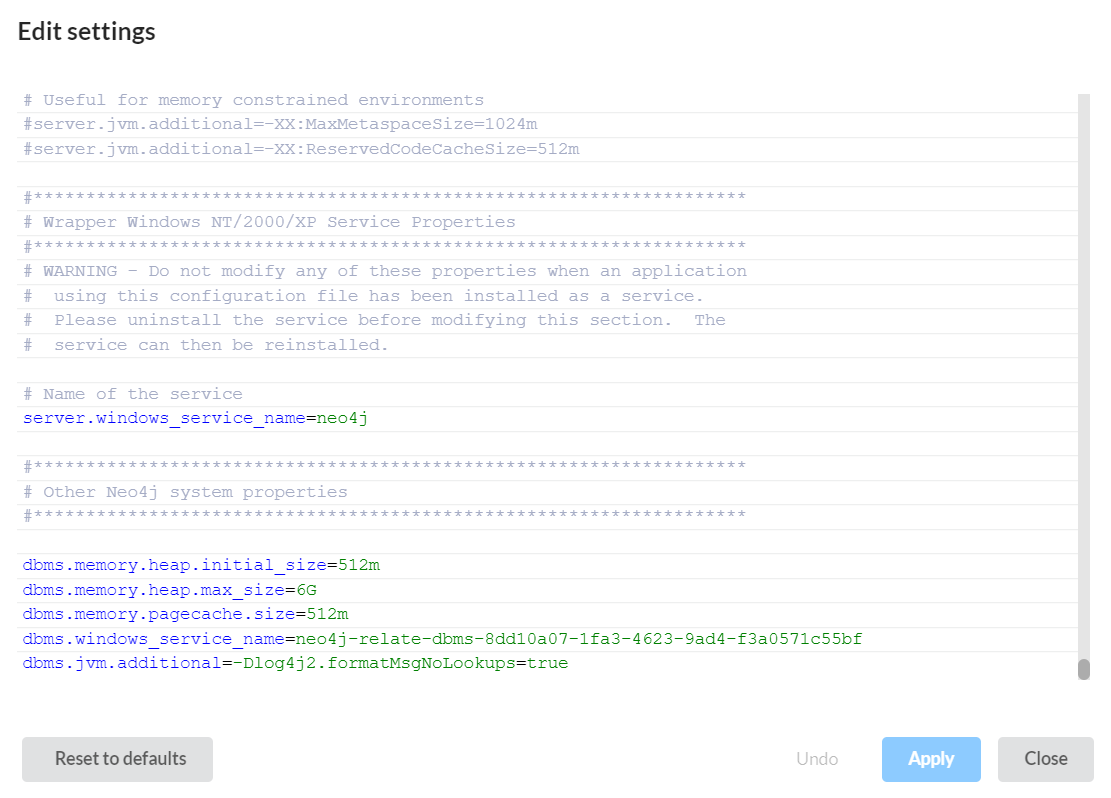

## Import the dataset to Neo4j

To import the dataset to neo4j first:
​
* Open the import folder
​
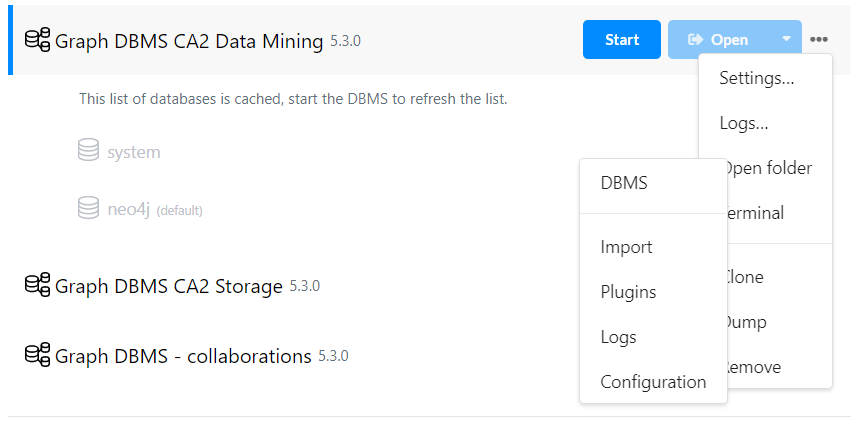
​
* Copy and past the dataset in the import folder
* Press the start button to run the neo4j sandbox
* When running, you will receive a notification that the process was successful
* Finally, open the virtual sandbox by selecting the open button and Neo4j Browser option.
* **At this point, you should have neo4j running in your localhost and ready to start coding in your notebook**

# Coding in Jupyter Notebook

In [1]:
# !pip install py2neo pandas

In [1]:
import numpy as np 
import pandas as pd
from py2neo import Graph
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import time
import warnings
warnings.filterwarnings("ignore")


C:\Users\Pranjali\AppData\Local\Temp\ipykernel_24008\135117476.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [201]:
LIMIT = 250000

In [203]:
df = pd.read_csv('C:\\Users\\Pranjali\\.Neo4jDesktop\\relate-data\\dbmss\\dbms-edb57687-79b6-46fa-aec2-2e2e779e575c\\import\\n_movies.csv')
df.head()
df.dropna(inplace=True)
df = df.iloc[:int((len(df)))]
df

,title,year,certificate,duration,genre,rating,description,stars,votes
0,Cobra Kai,(2018– ),TV-14,30 min,"Action, Comedy, Drama",8.500,Decades after their 1984 All Valley Karate Tou...,"['Ralph Macchio, ', 'William Zabka, ', 'Courtn...","177,031"
1,The Crown,(2016– ),TV-MA,58 min,"Biography, Drama, History",8.700,Follows the political rivalries and romance of...,"['Claire Foy, ', 'Olivia Colman, ', 'Imelda St...","199,885"
2,Better Call Saul,(2015–2022),TV-MA,46 min,"Crime, Drama",8.900,The trials and tribulations of criminal lawyer...,"['Bob Odenkirk, ', 'Rhea Seehorn, ', 'Jonathan...","501,384"
3,Devil in Ohio,(2022),TV-MA,356 min,"Drama, Horror, Mystery",5.900,When a psychiatrist shelters a mysterious cult...,"['Emily Deschanel, ', 'Sam Jaeger, ', 'Gerardo...","9,773"
4,Cyberpunk: Edgerunners,(2022– ),TV-MA,24 min,"Animation, Action, Adventure",8.600,A Street Kid trying to survive in a technology...,"['Zach Aguilar, ', 'Kenichiro Ohashi, ', 'Emi ...","15,413"
...,...,...,...,...,...,...,...,...,...
9952,The Imperfects,(2022– ),TV-MA,45 min,"Action, Adventure, Drama",6.300,After an experimental gene therapy turns them ...,"['Morgan Taylor Campbell, ', 'Italia Ricci, ',...","3,130"
9953,The Walking Dead,(2010–2022),TV-MA,44 min,"Drama, Horror, Thriller",8.100,Sheriff Deputy Rick Grimes wakes up from a com...,"['Andrew Lincoln, ', 'Norman Reedus, ', 'Melis...","970,067"
9954,The Crown,(2016– ),TV-MA,58 min,"Biography, Drama, History",8.700,Follows the political rivalries and romance of...,"['Claire Foy, ', 'Olivia Colman, ', 'Imelda St...","199,898"
9955,Supernatural,(2005–2020),TV-14,44 min,"Drama, Fantasy, Horror",8.400,Two brothers follow their father's footsteps a...,"['Jared Padalecki, ', 'Jensen Ackles, ', 'Jim ...","439,601"


#### set a movie id by getting unique movie names

In [205]:
all_movies = list(df['title'].unique())

In [206]:
# all_movies
movie_ids = dict()
for i in range(len(all_movies)):
    movie_ids[all_movies[i]] = f'M{i+1}'


In [207]:
movie_ids

{'Cobra Kai': 'M1',
 'The Crown': 'M2',
 'Better Call Saul': 'M3',
 'Devil in Ohio': 'M4',
 'Cyberpunk: Edgerunners': 'M5',
 'The Sandman': 'M6',
 'Rick and Morty': 'M7',
 'Breaking Bad': 'M8',
 'The Imperfects': 'M9',
 'Blonde': 'M10',
 'Stranger Things': 'M11',
 'End of the Road': 'M12',
 'The Walking Dead': 'M13',
 'Glass Onion: A Knives Out Mystery': 'M14',
 'Do Revenge': 'M15',
 'I Came By': 'M16',
 'No Limit': 'M17',
 'Peaky Blinders': 'M18',
 'The Lord of the Rings: The Fellowship of the Ring': 'M19',
 "Grey's Anatomy": 'M20',
 'Supernatural': 'M21',
 'American Horror Story': 'M22',
 'The Accidental Narco': 'M23',
 'NCIS': 'M24',
 'Friends': 'M25',
 'Shameless': 'M26',
 'Modern Family': 'M27',
 'Ozark': 'M28',
 'Echoes': 'M29',
 'The Gray Man': 'M30',
 'Me Time': 'M31',
 'Suits': 'M32',
 'Vikings': 'M33',
 'The Witcher': 'M34',
 'The Blacklist': 'M35',
 'Seinfeld': 'M36',
 'Lucifer': 'M37',
 'The Umbrella Academy': 'M38',
 'The Last Kingdom': 'M39',
 'Partner Track': 'M40',
 'Lo

In [208]:
import re

df["movie_id"] = df["title"].apply(lambda x: movie_ids.get(x))
df['start_year'] = df['year'].apply(lambda x: re.findall(r'\b\d{4}\b', x)[0])
df = df[['movie_id', 'title', 'start_year', 'certificate', 'duration', 'genre', 'rating',
       'description', 'stars', 'votes']]

In [209]:
df

,movie_id,title,start_year,certificate,duration,genre,rating,description,stars,votes
0,M1,Cobra Kai,2018,TV-14,30 min,"Action, Comedy, Drama",8.500,Decades after their 1984 All Valley Karate Tou...,"['Ralph Macchio, ', 'William Zabka, ', 'Courtn...","177,031"
1,M2,The Crown,2016,TV-MA,58 min,"Biography, Drama, History",8.700,Follows the political rivalries and romance of...,"['Claire Foy, ', 'Olivia Colman, ', 'Imelda St...","199,885"
2,M3,Better Call Saul,2015,TV-MA,46 min,"Crime, Drama",8.900,The trials and tribulations of criminal lawyer...,"['Bob Odenkirk, ', 'Rhea Seehorn, ', 'Jonathan...","501,384"
3,M4,Devil in Ohio,2022,TV-MA,356 min,"Drama, Horror, Mystery",5.900,When a psychiatrist shelters a mysterious cult...,"['Emily Deschanel, ', 'Sam Jaeger, ', 'Gerardo...","9,773"
4,M5,Cyberpunk: Edgerunners,2022,TV-MA,24 min,"Animation, Action, Adventure",8.600,A Street Kid trying to survive in a technology...,"['Zach Aguilar, ', 'Kenichiro Ohashi, ', 'Emi ...","15,413"
...,...,...,...,...,...,...,...,...,...,...
9952,M9,The Imperfects,2022,TV-MA,45 min,"Action, Adventure, Drama",6.300,After an experimental gene therapy turns them ...,"['Morgan Taylor Campbell, ', 'Italia Ricci, ',...","3,130"
9953,M13,The Walking Dead,2010,TV-MA,44 min,"Drama, Horror, Thriller",8.100,Sheriff Deputy Rick Grimes wakes up from a com...,"['Andrew Lincoln, ', 'Norman Reedus, ', 'Melis...","970,067"
9954,M2,The Crown,2016,TV-MA,58 min,"Biography, Drama, History",8.700,Follows the political rivalries and romance of...,"['Claire Foy, ', 'Olivia Colman, ', 'Imelda St...","199,898"
9955,M21,Supernatural,2005,TV-14,44 min,"Drama, Fantasy, Horror",8.400,Two brothers follow their father's footsteps a...,"['Jared Padalecki, ', 'Jensen Ackles, ', 'Jim ...","439,601"


In [210]:
# df['start_year'] = df['year'].apply(lambda x: x[1:5])
df['start_year'] = df['start_year'].astype(int)

## Connection neo4j and jupyter notebook

In [211]:
#In this code just change the password for your password
graph = Graph("bolt://localhost", auth=("neo4j", "pranjali30"))

In [212]:
#Set true to load all the nodes and relationship
LOAD_DATA = True
#Set False after creating all the nodes to avoid creating them again

def run_request(request,LOAD_DATA=False):
    if (LOAD_DATA):
        start_time = time.time()
        print(graph.run(request)) 
        exec_time = time.time() - start_time
        print(f'-- {exec_time} seconds --')

In [213]:
# DELETE ALL NODES AND RELATIONSHIPS
request_delete ="""
MATCH (n) DETACH DELETE n;
"""
run_request(request_delete,LOAD_DATA)

(No data)
-- 2.2298178672790527 seconds --


In [214]:
# CREATE MOVIES

request ="""
CREATE (m:Movie {id: $movie_id,title: $title})
SET 
m.start_year = $start_year,
m.certificate = $certificate,
m.duration_min = $duration_min, 
m.genre = $genre,
m.rating = $rating,
m.stars = $stars,
m.votes = $votes
"""
start_time = time.time()
count=df.shape[0]
if (LOAD_DATA):
    for index, row in df.iterrows():
        graph.run(request,
                  movie_id=row['movie_id'],
                  title=row['title'],        
                  duration_min=None if pd.isnull(row['duration']) else row['duration'],
                  genre=None if pd.isnull(row['genre']) else row['genre'],
                  certificate=None if pd.isnull(row['certificate']) else row['certificate'],
                  stars= None if pd.isnull(row['stars']) else row['stars'],
                  start_year=None if pd.isnull(row['start_year']) else row['start_year'],
                  rating=None if pd.isnull(row['rating']) else row['rating'],
                  votes=None if pd.isnull(row['votes']) else row['votes']
                  )
        if (index%500==0):
            exec_time = time.time() - start_time
            print(f'{index}/{df.shape[0]} done ... -- {exec_time} seconds --')
        
    exec_time = time.time() - start_time
    print(f' ... End ... -- {exec_time} seconds --')     

0/5754 done ... -- 0.0078084468841552734 seconds --
500/5754 done ... -- 1.1337120532989502 seconds --
1000/5754 done ... -- 2.2877471446990967 seconds --
2500/5754 done ... -- 5.134063959121704 seconds --
3000/5754 done ... -- 5.896615028381348 seconds --
3500/5754 done ... -- 6.650028705596924 seconds --
7000/5754 done ... -- 10.104954957962036 seconds --
7500/5754 done ... -- 10.313771486282349 seconds --
9000/5754 done ... -- 11.966535329818726 seconds --
9500/5754 done ... -- 12.73078989982605 seconds --
 ... End ... -- 13.478882312774658 seconds --


In [215]:
# CREATE  PERSONS
request ="""
MATCH (m:Movie)
WHERE m.stars IS NOT NULL
WITH m
UNWIND split(m.stars, ',') AS actor
MERGE (a:Actor {name: trim(actor)})
MERGE (a)-[r:ACTED_IN]->(m);
"""    
run_request(request,LOAD_DATA)   

(No data)
-- 188.34439873695374 seconds --


In [216]:
# CREATE CATEGORIES    
request ="""    
MATCH (m:Movie)
WHERE m.genre IS NOT NULL
WITH m
UNWIND split(m.genre, ',') AS genre
MERGE (g:Genre {name: trim(genre)})
MERGE (m)-[r:IN_GENRE]->(g);
"""    
run_request(request,LOAD_DATA)

(No data)
-- 0.20551490783691406 seconds --


In [217]:
# DELETE UNUSED PROPERTY
request="""
MATCH(m:Movie)
SET m.country = null, m.category = null,m.type = null , m.director = null , m.cast =null
"""
run_request(request,LOAD_DATA) 

(No data)
-- 0.016204118728637695 seconds --


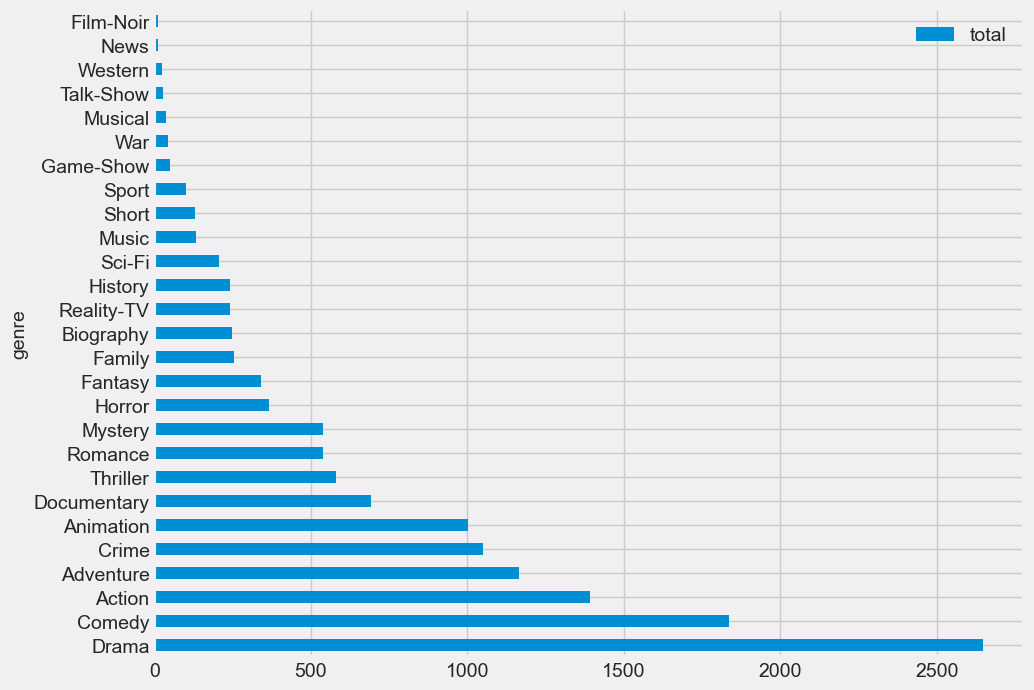

In [218]:
request="""
MATCH (g:Genre)<-[rel:IN_GENRE]-(m:Movie)
WITH g.name as genre,count(*) as total
RETURN  genre,total
ORDER BY total DESC
"""
result = graph.run(request).to_data_frame()
result.plot.barh(x='genre', y='total',figsize=(10,8))
plt.show()

In [219]:
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
2,Genre,27
0,Movie,5754
1,Actor,17626


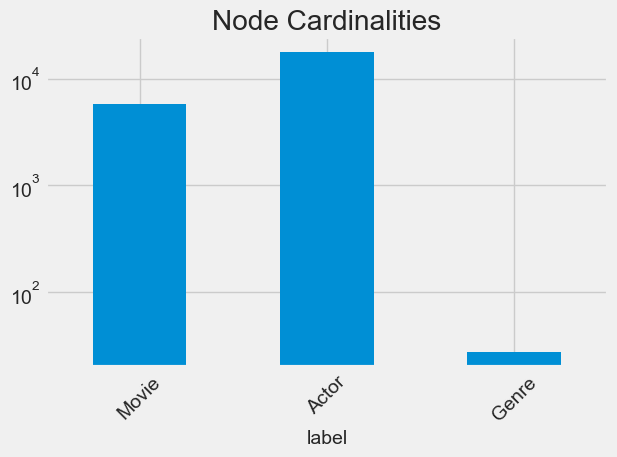

In [220]:
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [221]:
#Shortest Path analysis

def who_be_present(I_AM,I_WANT_TO_MEET):
    print(f"I'm {I_AM}")
    print(f"I want to meet {I_WANT_TO_MEET}")
    request="""
MATCH p = shortestPath((start:Actor)-[:WORK_WITH*]-(end:Actor))
WHERE start.name = $pfrom AND end.name = $pto
RETURN p
    
    """
    cursor = graph.run(request,pfrom=I_AM,pto=I_WANT_TO_MEET)
    while cursor.forward():
        print(cursor['p'])
    print('\n')
        
        
I_AM='Johnny Yong Bosch'
I_WANT_TO_MEET='Jakob Eklund'
who_be_present(I_AM,I_WANT_TO_MEET)

I_AM='Matt Smith'
I_WANT_TO_MEET='Johnny Yong Bosch'
who_be_present(I_AM,I_WANT_TO_MEET)

I'm Johnny Yong Bosch
I want to meet Jakob Eklund


I'm Matt Smith
I want to meet Johnny Yong Bosch




## Splitting the dataset

Based on the graph presented above, all the movies released before 2020 are taken as training dataset and the movies released in 2020 onwards are taken as testing dataset

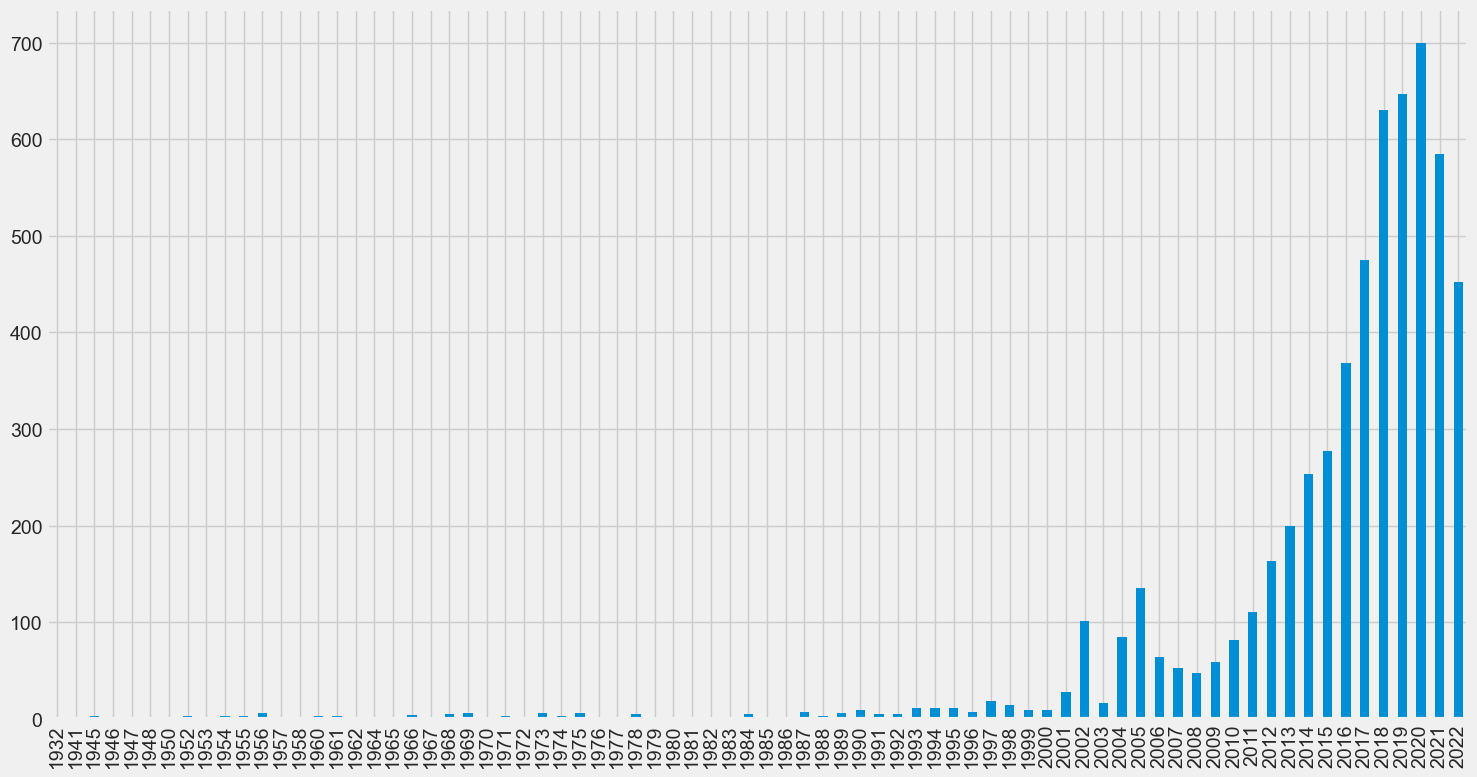

In [222]:
query = """
MATCH (m:Movie) WHERE (m.start_year) IS NOT NULL
WITH m.start_year AS start_year, count(*) AS count
ORDER BY start_year
RETURN toString(start_year) AS start_year, count
"""
by_year = graph.run(query).to_data_frame()

ax = by_year.plot(kind='bar', x='start_year', y='count', legend=None, figsize=(15,8))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

In [223]:
#Creating work_with relationship
query = """
MATCH (a:Actor)-[rel:ACTED_IN]->(movie)<-[:ACTED_IN]-(a2:Actor)
WITH a, a2, movie
ORDER BY a, movie.start_year
WHERE a.name IS NOT NULL AND a2.name IS NOT NULL
WITH a, a2, collect(movie)[0].start_year AS start_year, count(*) AS collaborations
MERGE (a)-[work_with:WORK_WITH {start_year: start_year}]-(a2)
SET work_with.collaborations = collaborations;
"""

graph.run(query).stats()

{'relationships_created': 84094, 'properties_set': 252282}

In [224]:
#Creating work_with_early relationship (train dataset)
query = """
MATCH (a:Actor)-[rel:ACTED_IN]->(movie)<-[:ACTED_IN]-(a2:Actor)
WITH a, a2, movie
ORDER BY a, movie.start_year
WITH a, a2, min(movie.start_year) AS start_year, count(*) AS collaborations
WHERE start_year <= 2021
MERGE (a)-[work_with:WORK_WITH_EARLY {start_year: start_year}]-(a2)
SET work_with.collaborations = collaborations;
"""

graph.run(query).stats()

{'relationships_created': 78143, 'properties_set': 234429}

In [225]:
#Creating work_with_late relationship (test dataset)
query = """
MATCH (a:Actor)-[rel:ACTED_IN]->(movie)<-[:ACTED_IN]-(a2:Actor)
WITH a, a2, movie
ORDER BY a, movie.start_year
WITH a, a2, collect(movie)[0].start_year AS start_year, count(*) AS collaborations
WHERE start_year = 2022
MERGE (a)-[work_with:WORK_WITH_LATE {start_year: start_year}]-(a2)
SET work_with.collaborations = collaborations;
"""

graph.run(query).stats()

{'relationships_created': 5951, 'properties_set': 17853}

In [226]:
result = {"relType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

,relType,count
4,WORK_WITH_LATE,5951
1,IN_GENRE,13909
0,ACTED_IN,40195
3,WORK_WITH_EARLY,78143
2,WORK_WITH,84094


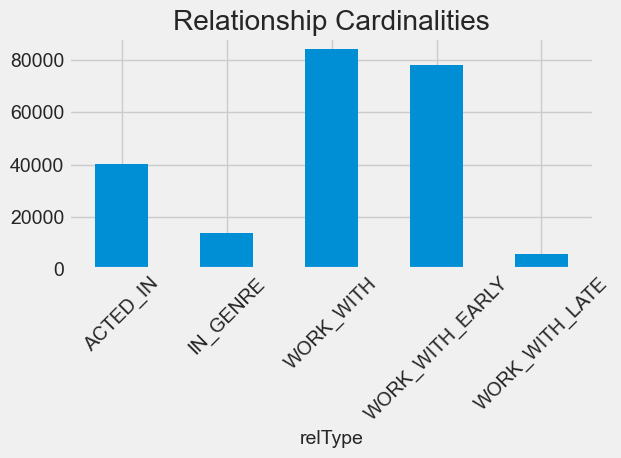

In [227]:
rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [228]:
query = """
MATCH ()-[:WORK_WITH_EARLY]->()
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,78143


In [229]:
query = """
MATCH ()-[:WORK_WITH_LATE]->()
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,5951


## Down sampling the unconnected nodes

Due to the number of no related nodes (or actors who haven't collaborated before) is higher than the number of nodes related (unbalanced data). We need to downsampling the unrelated nodes to the same number of connected nodes.

* The actors who have collaborated before are represented with the number 1.

* The actors who haven't collaborated before are represented with the number 0.

In [303]:
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = (zero - un)
    if n < 0:
        copy = copy.drop(copy[copy.label == 1].sample(n=abs(n), random_state=1).index)
    elif n >= 0:
        copy = copy.drop(copy[copy.label == 0].sample(n=abs(n), random_state=1).index)
    return copy.sample(frac=1)

#### Adding limit 50000 to train_missing_links due to neo4j heap size issue

In [304]:
zero

3117

In [305]:
un

12574

In [306]:
#Correcting unbalanced issue in the training dataset

train_existing_links = graph.run("""
MATCH (a:Actor)-[:WORK_WITH_EARLY]->(other:Actor)
RETURN id(a) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

# train_missing_links = graph.run("""
# MATCH (a:Actor)
# WHERE (a)-[:WORK_WITH_EARLY]-()
# MATCH (a)-[:WORK_WITH_EARLY*2..3]-(other)
# WHERE not((a)-[:WORK_WITH_EARLY]-(other))
# RETURN id(a) AS node1, id(other) AS node2, 0 AS label
# """).to_data_frame()

train_missing_links = graph.run(f"""
MATCH (a:Actor)-[:WORK_WITH_EARLY*2..3]-(other)
WHERE not((a)-[:WORK_WITH_EARLY]-(other))
RETURN id(a) AS node1, id(other) AS node2, 0 AS label
LIMIT {LIMIT}
""").to_data_frame()

train_missing_links = train_missing_links.drop_duplicates()

In [307]:
train_missing_links

,node1,node2,label
0,0,0,0
2,0,1135,0
3,0,6410,0
4,0,462,0
5,0,6778,0
...,...,...,...
38788,0,14985,0
38795,0,9144,0
38797,0,11116,0
38804,0,15432,0


In [308]:
training_df = pd.concat([train_missing_links, train_existing_links], ignore_index=True)
training_df['label'] = training_df['label'].astype('category')

In [309]:
copy = training_df.copy()
# return copy.sample(frac=1)
copy

,node1,node2,label
0,0,0,0
1,0,1135,0
2,0,6410,0
3,0,462,0
4,0,6778,0
...,...,...,...
94342,8565,23379,1
94343,11822,23379,1
94344,5694,23379,1
94345,8527,23379,1


In [311]:
training_df = pd.concat([train_missing_links, train_existing_links], ignore_index=True)
training_df['label'] = training_df['label'].astype('category')
training_df = down_sample(training_df)
train_existing_links

,node1,node2,label
0,1,2,1
1,1,3,1
2,2,3,1
3,1,4,1
4,3,4,1
...,...,...,...
78138,8565,23379,1
78139,11822,23379,1
78140,5694,23379,1
78141,8527,23379,1


In [320]:
training_df

,node1,node2,label
36982,11114,11117,1
10296,0,22082,0
25247,439,8565,1
32153,8564,9915,1
88553,8565,22453,1
...,...,...,...
35802,6796,10835,1
8648,0,19895,0
44093,8564,12762,1
89529,8565,22595,1


In [312]:
training_df.head()

,node1,node2,label
36982,11114,11117,1
10296,0,22082,0
25247,439,8565,1
32153,8564,9915,1
88553,8565,22453,1


In [313]:
#balanced training dataset
training_df.groupby("label").count()

,node1,node2
label,,
0,16204,16204
1,16204,16204


In [314]:
#Correcting unbalanced issue in the testing dataset

test_existing_links = graph.run("""
MATCH (a:Actor)-[:WORK_WITH_LATE]->(other:Actor)
RETURN id(a) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

test_missing_links = graph.run(f"""
MATCH (a:Actor)
WHERE (a)-[:WORK_WITH_LATE]-()
MATCH (a)-[:WORK_WITH_LATE*2..3]-(other)
WHERE not((a)-[:WORK_WITH_LATE]-(other))
RETURN id(a) AS node1, id(other) AS node2, 0 AS label
LIMIT {LIMIT}
""").to_data_frame()
test_missing_links = test_missing_links.drop_duplicates()

In [315]:
test_df = pd.concat([test_missing_links, test_existing_links], ignore_index=True)
test_df['label'] = test_df['label'].astype('category')
test_df = down_sample(test_df)

In [316]:
test_df

,node1,node2,label
41920,14996,14999,1
5301,13,14159,0
1677,11,6062,0
41017,10687,10688,1
19864,112,9319,0
...,...,...,...
37909,6461,8564,1
37801,6240,6670,1
13800,109,1300,0
1020,10,10654,0


In [317]:
test_df.head()

,node1,node2,label
41920,14996,14999,1
5301,13,14159,0
1677,11,6062,0
41017,10687,10688,1
19864,112,9319,0


In [318]:
#balanced testing dataset
test_df.groupby("label").count()

,node1,node2
label,,
0,5951,5951
1,5951,5951


## Choosing a machine learning algorithm

In [319]:
#Random Forest Classifier used as model
classifier = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0)

### Calculating grahp parameters (cn, pa, tn)

In [321]:
def apply_graphy_features(data, rel_type):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           gds.alpha.linkprediction.commonNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS cn,
           gds.alpha.linkprediction.preferentialAttachment(
               p1, p2, {relationshipQuery: $relType}) AS pa,
           gds.alpha.linkprediction.totalNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS tn
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    features = graph.run(query, {"pairs": pairs, "relType": rel_type}).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [322]:
training_df = apply_graphy_features(training_df, "WORK_WITH_EARLY")

In [323]:
training_df.head()

,node1,node2,label,cn,pa,tn
0,11114,11117,1,3.000,16.000,5.000
1,0,22082,0,3.000,70.000,14.000
2,439,8565,1,6.000,78869.000,11268.000
3,8564,9915,1,10.000,126577.000,11508.000
4,8565,22453,1,10.000,123937.000,11268.000


In [324]:
test_df = apply_graphy_features(test_df, "WORK_WITH_LATE")

In [325]:
test_df.head()

,node1,node2,label,cn,pa,tn
0,14996,14999,1,3.000,24.000,7.000
1,13,14159,0,0.000,16.000,8.000
2,11,6062,0,0.000,32.000,12.000
3,10687,10688,1,6.000,49.000,8.000
4,112,9319,0,0.000,12.000,7.000


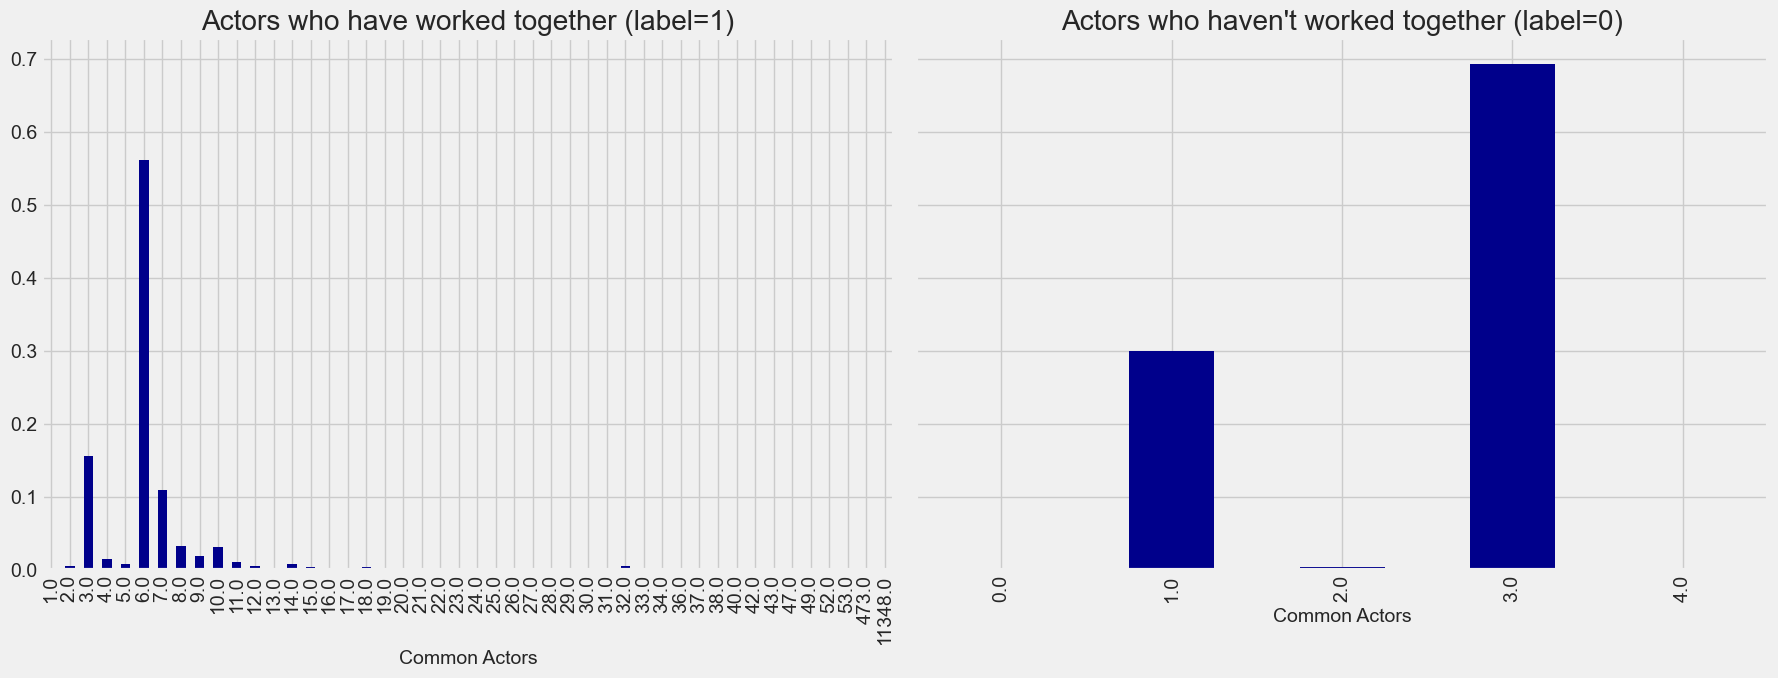

In [326]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have worked together"), (0, "haven't worked together")]
for index, chart in enumerate(charts):
 label, title = chart
 filtered = training_df[training_df["label"] == label]
 common_actors = filtered["cn"]
 histogram = common_actors.value_counts().sort_index()
 histogram /= float(histogram.sum())
 histogram.plot(kind="bar", x='Common Actors', color="darkblue",
 ax=axs[index], title=f"Actors who {title} (label={label})")
 axs[index].xaxis.set_label_text("Common Actors")
plt.tight_layout()
plt.show()

### Model 1: using just 'cn' as feature

In [327]:
columns = ["cn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display("Accuracy", accuracy_score(y_test, predictions))
display("Precision", precision_score(y_test, predictions))
display("Recall", recall_score(y_test, predictions))
display("AUC",roc_auc_score(y_test, predictions))

sorted(list(zip(columns, classifier.feature_importances_)), key = lambda x: x[1]*-1)

'Accuracy'

0.755083179297597

'Precision'

0.9782608695652174

'Recall'

0.5217610485632667

'AUC'

0.755083179297597

[('cn', 1.0)]

In [328]:
#Model results
results = pd.DataFrame([accuracy_score(y_test, predictions),precision_score(y_test, predictions),recall_score(y_test, predictions),roc_auc_score(y_test, predictions)], index=["Accuracy", "Precision", "Recall", "AUC"], columns=["Model 1"])
results

,Model 1
Accuracy,0.755
Precision,0.978
Recall,0.522
AUC,0.755


### Model 2: using 'cn', 'pa', and 'tn' as features

In [329]:
columns = ["cn", "pa", "tn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display("Accuracy", accuracy_score(y_test, predictions))
display("Precision", precision_score(y_test, predictions))
display("Recall", recall_score(y_test, predictions))
display("AUC",roc_auc_score(y_test, predictions))

sorted(list(zip(columns, classifier.feature_importances_)), key = lambda x: x[1]*-1)

'Accuracy'

0.8223827928079315

'Precision'

0.7571371129875352

'Recall'

0.9492522265165518

'AUC'

0.8223827928079314

[('cn', 0.45274324190972765),
 ('tn', 0.31428939316409493),
 ('pa', 0.23296736492617748)]

In [330]:
#Results
m2l = [accuracy_score(y_test, predictions),precision_score(y_test, predictions),recall_score(y_test, predictions),roc_auc_score(y_test, predictions)]
results['Model 2'] = m2l
results

,Model 1,Model 2
Accuracy,0.755,0.822
Precision,0.978,0.757
Recall,0.522,0.949
AUC,0.755,0.822


### Calculating triangle counts and cluster coefficient

In [332]:
graph.run("""
CALL gds.graph.project(
  'Actor',
  'Actor',
  {WORK_WITH_EARLY: {orientation: 'UNDIRECTED'}}
  
)
"""
).to_data_frame()

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Actor': {'label': 'Actor', 'properties': {}}}",{'WORK_WITH_EARLY': {'orientation': 'UNDIRECTE...,Actor,17626,156286,44


In [333]:
graph.run("""
CALL gds.triangleCount.write('Actor',{
 writeProperty: 'trianglesTrain'
});

""").to_data_frame()

,writeMillis,nodePropertiesWritten,globalTriangleCount,nodeCount,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,37,17626,180315,17626,0,0,56,{'jobId': '82bac918-dc32-46cf-a450-78b43fd87b9...


In [334]:
graph.run("""
CALL gds.graph.project(
  'ActorLate',
  'Actor',
  {WORK_WITH_LATE: {orientation: 'UNDIRECTED'}}
  
)
"""
).to_data_frame()

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Actor': {'label': 'Actor', 'properties': {}}}",{'WORK_WITH_LATE': {'orientation': 'UNDIRECTED...,ActorLate,17626,11902,12


In [335]:
graph.run("""
CALL gds.triangleCount.write('ActorLate',{
 writeProperty: 'trianglesTest'
});

""").to_data_frame()

,writeMillis,nodePropertiesWritten,globalTriangleCount,nodeCount,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,59,17626,7253,17626,0,0,7,{'jobId': '9176825b-add7-4393-bb0c-f0c5b4b3676...


In [336]:
graph.run("""
CALL gds.graph.project(
  'ActorCluste1',
  'Actor',
  {WORK_WITH_LATE: {orientation: 'UNDIRECTED'}}
)
"""
).to_data_frame()

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Actor': {'label': 'Actor', 'properties': {}}}",{'WORK_WITH_LATE': {'orientation': 'UNDIRECTED...,ActorCluste1,17626,11902,11


In [337]:
graph.run("""
CALL gds.localClusteringCoefficient.write('ActorCluste1',{
 writeProperty: 'coefficientTrain'
});
""").to_data_frame()

,writeMillis,nodePropertiesWritten,averageClusteringCoefficient,nodeCount,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,47,17626,0.081,17626,0,0,11,{'jobId': 'a639740c-3653-4f76-b9f0-c6b830e1c4a...


In [338]:
graph.run("""
CALL gds.graph.project(
  'ActorCluste2',
  'Actor',
  {WORK_WITH_LATE: {orientation: 'UNDIRECTED'}}
)
"""
).to_data_frame()

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Actor': {'label': 'Actor', 'properties': {}}}",{'WORK_WITH_LATE': {'orientation': 'UNDIRECTED...,ActorCluste2,17626,11902,10


In [339]:
graph.run("""
CALL gds.localClusteringCoefficient.write('ActorCluste2',{
 writeProperty: 'coefficientTest'
});
""").to_data_frame()

,writeMillis,nodePropertiesWritten,averageClusteringCoefficient,nodeCount,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,74,17626,0.081,17626,0,0,10,{'jobId': '29fc9ac3-86c4-4fda-bbfa-7a7a01132e8...


In [340]:
def apply_triangles_features(data, triangles_prop, coefficient_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]]) AS minTriangles,
    apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]]) AS maxTriangles,
    apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]]) AS minCoefficient,
    apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]]) AS maxCoefficient
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "trianglesProp": triangles_prop,
    "coefficientProp": coefficient_prop
    }
    features = graph.run(query, params).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [341]:
#Uncomment to create the the 4 new features and add them to the dataframe
training_df = apply_triangles_features(training_df, "trianglesTrain", "coefficientTrain")
test_df = apply_triangles_features(test_df, "trianglesTest", "coefficientTest")

In [342]:
training_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient
0,11114,11117,1,3.000,16.000,5.000,6,6,0.000,0.000
1,0,22082,0,3.000,70.000,14.000,21,34,0.000,0.000
2,439,8565,1,6.000,78869.000,11268.000,21,52698,0.000,0.005
3,8564,9915,1,10.000,126577.000,11508.000,39,53309,0.000,0.004
4,8565,22453,1,10.000,123937.000,11268.000,39,52698,0.000,0.005


In [343]:
test_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient
0,14996,14999,1,3.000,24.000,7.000,6,9,0.600,1.000
1,13,14159,0,0.000,16.000,8.000,4,6,0.667,1.000
2,11,6062,0,0.000,32.000,12.000,6,19,0.679,1.000
3,10687,10688,1,6.000,49.000,8.000,12,12,0.571,0.571
4,112,9319,0,0.000,12.000,7.000,3,5,0.833,1.000


### Model 3: using graph parameters (cn, pa, tn), triangles, and cluste coefficients as features

In [344]:
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient" # triangle features  
]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display("Accuracy", accuracy_score(y_test, predictions))
display("Precision", precision_score(y_test, predictions))
display("Recall", recall_score(y_test, predictions))
display("AUC",roc_auc_score(y_test, predictions))

sorted(list(zip(columns, classifier.feature_importances_)), key = lambda x: x[1]*-1)

'Accuracy'

0.5004200974626113

'Precision'

0.50021013700933

'Recall'

1.0

'AUC'

0.5004200974626114

[('cn', 0.3335522218322378),
 ('maxTriangles', 0.2349969790076261),
 ('tn', 0.2335245507974296),
 ('pa', 0.11130768604793448),
 ('maxCoefficient', 0.04981033401001864),
 ('minTriangles', 0.03670470506775692),
 ('minCoefficient', 0.00010352323699650454)]

In [345]:
#Results
m3l = [accuracy_score(y_test, predictions),precision_score(y_test, predictions),recall_score(y_test, predictions),roc_auc_score(y_test, predictions)]
results['Model 3'] = m3l
results

,Model 1,Model 2,Model 3
Accuracy,0.755,0.822,0.500
Precision,0.978,0.757,0.500
Recall,0.522,0.949,1.000
AUC,0.755,0.822,0.500


### Calculating the community detection coefficients

In [346]:
graph.run("""
CALL gds.labelPropagation.write('Actor',{
 writeProperty: "partitionTrain"
});
""").to_data_frame()

,writeMillis,nodePropertiesWritten,ranIterations,didConverge,communityCount,communityDistribution,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,51,17626,8,True,1686,"{'p99': 11, 'min': 1, 'max': 14623, 'mean': 10...",8,0,2377,{'jobId': '79d2412b-f659-4dbf-b944-7b5c808d83a...


In [347]:
graph.run("""
CALL gds.labelPropagation.write('ActorLate',{
 writeProperty: "partitionTest"
});
""").to_data_frame()

,writeMillis,nodePropertiesWritten,ranIterations,didConverge,communityCount,communityDistribution,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,38,17626,5,True,16007,"{'p99': 1, 'min': 1, 'max': 1266, 'mean': 1.10...",15,0,117,{'jobId': '0681e214-b8ef-40ca-a13c-fed75ae67cc...


In [348]:
graph.run("""
CALL gds.louvain.stream('Actor',{
 includeIntermediateCommunities: true
})
YIELD nodeId, communityId, intermediateCommunityIds
WITH gds.util.asNode(nodeId) AS node,
 intermediateCommunityIds[0] AS smallestCommunity
SET node.louvainTrain = smallestCommunity;
""").stats()

{'properties_set': 17626}

In [349]:
graph.run("""
CALL gds.louvain.stream('ActorLate',{
 includeIntermediateCommunities: true
})
YIELD nodeId, communityId, intermediateCommunityIds
WITH gds.util.asNode(nodeId) AS node,
 intermediateCommunityIds[0] AS smallestCommunity
SET node.louvainTest = smallestCommunity;
""").stats()

{'properties_set': 17626}

In [350]:
def apply_community_features(data, partition_prop, louvain_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    gds.alpha.linkprediction.sameCommunity(p1, p2, $partitionProp) AS sp,    
    gds.alpha.linkprediction.sameCommunity(p1, p2, $louvainProp) AS sl
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "partitionProp": partition_prop,
    "louvainProp": louvain_prop
    }
    features = graph.run(query, params).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [351]:
training_df = apply_community_features(training_df, "partitionTrain", "louvainTrain")
test_df = apply_community_features(test_df, "partitionTest", "louvainTest")

In [352]:
training_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient,sp,sl
0,11114,11117,1,3.000,16.000,5.000,6,6,0.000,0.000,1.000,1.000
1,0,22082,0,3.000,70.000,14.000,21,34,0.000,0.000,1.000,0.000
2,439,8565,1,6.000,78869.000,11268.000,21,52698,0.000,0.005,1.000,0.000
3,8564,9915,1,10.000,126577.000,11508.000,39,53309,0.000,0.004,1.000,0.000
4,8565,22453,1,10.000,123937.000,11268.000,39,52698,0.000,0.005,1.000,0.000


In [353]:
test_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient,sp,sl
0,14996,14999,1,3.000,24.000,7.000,6,9,0.600,1.000,1.000,1.000
1,13,14159,0,0.000,16.000,8.000,4,6,0.667,1.000,0.000,0.000
2,11,6062,0,0.000,32.000,12.000,6,19,0.679,1.000,0.000,0.000
3,10687,10688,1,6.000,49.000,8.000,12,12,0.571,0.571,1.000,1.000
4,112,9319,0,0.000,12.000,7.000,3,5,0.833,1.000,0.000,0.000


### Model 4: using graph parameters (cn, pa, tn), triangles, cluste coefficients, and community detection coefficients as features

In [354]:
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient", # triangle features  
    "sp", "sl" # community features
]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display("Accuracy", accuracy_score(y_test, predictions))
display("Precision", precision_score(y_test, predictions))
display("Recall", recall_score(y_test, predictions))
display("AUC",roc_auc_score(y_test, predictions))
display("Confusion_matrix",confusion_matrix(y_test, predictions, labels = [0,1]))

sorted(list(zip(columns, classifier.feature_importances_)), key = lambda x: x[1]*-1)

'Accuracy'

0.5020164678205343

'Precision'

0.501010271089409

'Recall'

1.0

'AUC'

0.5020164678205343

'Confusion_matrix'

array([[  24, 5927],
       [   0, 5951]], dtype=int64)

[('cn', 0.374302543702434),
 ('maxTriangles', 0.2382985960771431),
 ('tn', 0.13240256546476972),
 ('pa', 0.098196475073493),
 ('sl', 0.08849924984684991),
 ('maxCoefficient', 0.03873729046920162),
 ('minTriangles', 0.029411334013510763),
 ('sp', 7.931034485534985e-05),
 ('minCoefficient', 7.263500774271767e-05)]

# Models results

In [355]:
m4l = [accuracy_score(y_test, predictions),precision_score(y_test, predictions),recall_score(y_test, predictions),roc_auc_score(y_test, predictions)]
results['Model 4'] = m4l
results

,Model 1,Model 2,Model 3,Model 4
Accuracy,0.755,0.822,0.500,0.502
Precision,0.978,0.757,0.500,0.501
Recall,0.522,0.949,1.000,1.000
AUC,0.755,0.822,0.500,0.502


In [356]:
def plot_feature_importance(fields, feature_importances):
 df = pd.DataFrame({"Feature": fields, "Importance": feature_importances})
 df = df.sort_values("Importance", ascending=False)
 ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None, color="blue", figsize=(13,10))
 ax.xaxis.set_label_text("")
 plt.tight_layout()
 plt.xticks(rotation=45)
 plt.show()

## Features importance

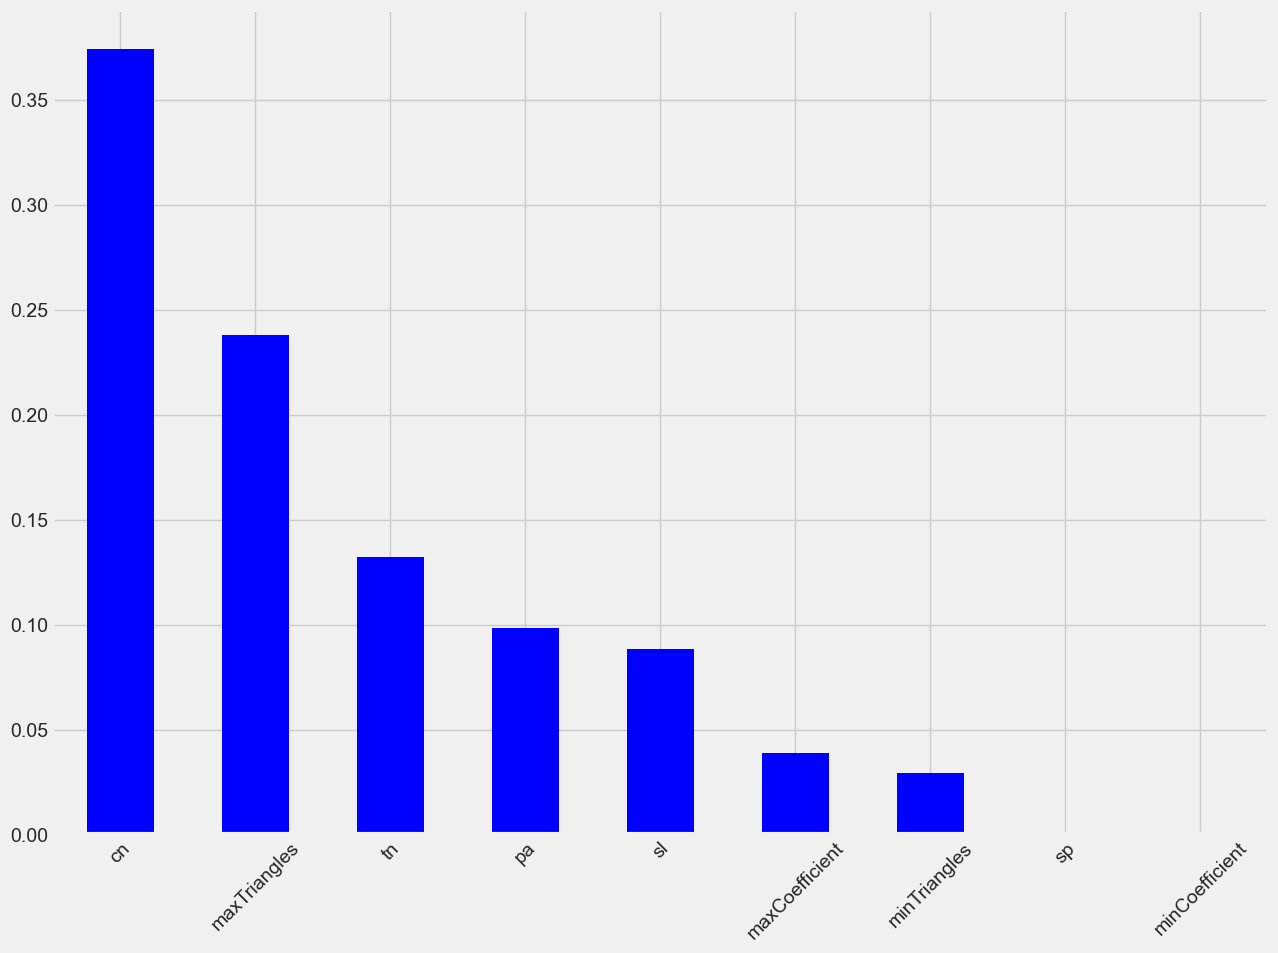

In [357]:
plot_feature_importance(columns, classifier.feature_importances_)

**Conclutions**: 

* Model 4 outstanded the rest of the models with and accuracy of 99% in predicting future collaborations between actors.

* According with the observations, the common Neighbors and the 2 community detection are the most important features when predicting relationships between nodes in this dataset.

***

**License**

This Notebook has been released under the [Apache 2.0](http://www.apache.org/licenses/LICENSE-2.0) open source license.